**Installing latest pickle to unserialize our data from database**

In [3]:
!pip install pickle5


**Adding needed imports**

In [4]:
from google.colab import drive
import os
import  pickle5 as pickle
from HandReading import HandReading
from Imu import Imu
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
drive.mount('/content/drive')

Mounted at /content/drive


**Creating dictionary mappers**


In [5]:
dict_word_id = {}
dict_id_word = {}

list_word = os.listdir('/content/drive/MyDrive/database') 
for j in range(len(list_word)) : 
  dict_word_id[list_word[j]] = j
  dict_id_word[j] = list_word[j]
print(dict_word_id)
print(dict_id_word)

{'23': 0, 'lucas': 1, 'oi': 2, 'silencio': 3, 'tchau': 4, 'tudo-bem': 5, 'qual-a-sua-idade': 6, 'prazer-em-te-conhecer': 7, 'meu-nome-e': 8, 'abdullah': 9, 'qual-seu-nome': 10}
{0: '23', 1: 'lucas', 2: 'oi', 3: 'silencio', 4: 'tchau', 5: 'tudo-bem', 6: 'qual-a-sua-idade', 7: 'prazer-em-te-conhecer', 8: 'meu-nome-e', 9: 'abdullah', 10: 'qual-seu-nome'}


**Preparing input and labels data**

In [6]:
input_data, output = [], []

list_word = os.listdir('/content/drive/MyDrive/database') 

for word in list_word:
  list_pickle_file = os.listdir(f'/content/drive/MyDrive/database/{word}')
  k = 0 
  for pickle_file in list_pickle_file:
    k+=1
    with open(f'/content/drive/MyDrive/database/{word}/{pickle_file}', 'rb') as input:
      readings = pickle.load(input)
      for reading in readings:
        finger = []
        for i in range(5):
          finger.append(np.float16(reading.imus[i].accel[0]/255.0))
          finger.append(np.float16(reading.imus[i].accel[1]/255.0))
          finger.append(np.float16(reading.imus[i].accel[2]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
          pass
      
        input_data.append(finger)
        
        out = np.zeros(11)
        out[dict_word_id[word]] = 1.0
        output.append(out)

input_data = np.array(input_data)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
output = np.array(output)

**Creating neural network model**

In [7]:
model = Sequential()

model.add(LSTM(units=50, input_shape=input_data[0].shape, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

**Separate data and train**

In [8]:
X, X_test, y, y_test = train_test_split(
    input_data, output, test_size=0.3, stratify=output, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42)

model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(X_valid, y_valid))

Epoch 1/50
2289/2289 - 36s - loss: 2.2044 - accuracy: 0.1846 - val_loss: 2.0140 - val_accuracy: 0.2456
Epoch 2/50
2289/2289 - 35s - loss: 1.9703 - accuracy: 0.2636 - val_loss: 1.8540 - val_accuracy: 0.3032
Epoch 3/50
2289/2289 - 34s - loss: 1.8512 - accuracy: 0.3074 - val_loss: 1.7460 - val_accuracy: 0.3473
Epoch 4/50
2289/2289 - 34s - loss: 1.7463 - accuracy: 0.3469 - val_loss: 1.6372 - val_accuracy: 0.3859
Epoch 5/50
2289/2289 - 34s - loss: 1.6391 - accuracy: 0.3837 - val_loss: 1.5268 - val_accuracy: 0.4239
Epoch 6/50
2289/2289 - 35s - loss: 1.5489 - accuracy: 0.4148 - val_loss: 1.4693 - val_accuracy: 0.4432
Epoch 7/50
2289/2289 - 34s - loss: 1.5010 - accuracy: 0.4312 - val_loss: 1.4402 - val_accuracy: 0.4515
Epoch 8/50
2289/2289 - 34s - loss: 1.4720 - accuracy: 0.4409 - val_loss: 1.4221 - val_accuracy: 0.4591
Epoch 9/50
2289/2289 - 34s - loss: 1.4522 - accuracy: 0.4506 - val_loss: 1.4264 - val_accuracy: 0.4614
Epoch 10/50
2289/2289 - 34s - loss: 1.4370 - accuracy: 0.4534 - val_loss:

**Predict using trained model**

In [9]:
prd = model.predict(X_test)

**Analyse accuracies**


In [10]:
pred = []
for j in range(len(prd)):
  lis = prd[j]
  arg = np.argmax(lis)
  pred.append(arg)
pred = np.array(pred)

y_one = []
for y in y_test :
  arg = np.argmax(y)
  y_one.append(arg)
y_one = np.array(y_one)

print(classification_report(y_one, pred))
print(dict_id_word)
print()
print(acc(y_one,pred))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59      5706
           1       0.56      0.52      0.54      5706
           2       0.42      0.52      0.46      5706
           3       1.00      1.00      1.00      5706
           4       0.74      0.52      0.61      5706
           5       0.36      0.46      0.40      5706
           6       0.39      0.36      0.37      5706
           7       0.23      0.29      0.25      5706
           8       0.60      0.49      0.54      5706
           9       0.43      0.58      0.50      5706
          10       0.56      0.40      0.47      5706

    accuracy                           0.51     62766
   macro avg       0.54      0.51      0.52     62766
weighted avg       0.54      0.51      0.52     62766

{0: '23', 1: 'lucas', 2: 'oi', 3: 'silencio', 4: 'tchau', 5: 'tudo-bem', 6: 'qual-a-sua-idade', 7: 'prazer-em-te-conhecer', 8: 'meu-nome-e', 9: 'abdullah', 10: 'qual-seu-nome'}

0.5141796

**Real life usage example**

In [11]:
with open(f'/content/drive/MyDrive/database/silencio/11.pkl', 'rb') as input:
  readings = pickle.load(input)
  input_test_data = []
  j = 0
  for reading in readings:
    finger = []
    for i in range(5):
      finger.append(np.float16(reading.imus[i].accel[0]/255.0))
      finger.append(np.float16(reading.imus[i].accel[1]/255.0))
      finger.append(np.float16(reading.imus[i].accel[2]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
    
  
    input_test_data.append(finger)
    
input_test_data = np.array(input_test_data)
input_test_data = input_test_data.reshape((input_test_data.shape[0], input_test_data.shape[1], 1))

for inputData in input_test_data:
  result1 = model.predict(inputData.reshape(1,30,1))
  print(dict_id_word[np.argmax(result1)])

23
silencio
lucas
lucas
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
silencio
sile

**Plot model structure**

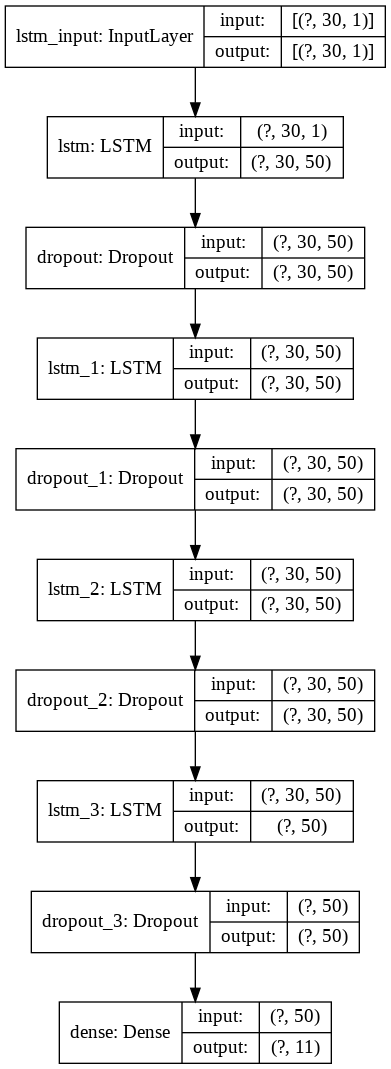

In [12]:
plot_model(model, to_file='topology.png',show_shapes=True)